# Importing Libraries

In [ ]:
# Mounting the drive, where the data file is present
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing useful libraries/packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, classification_report, precision_score
from google.colab import auth
import gspread
from google.auth import default
from scipy.optimize import Bounds
!pip install clogistic
from clogistic import LogisticRegression as cLogisticRegression
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Reading Data

In [ ]:
# Authenticating Google Account
auth.authenticate_user()
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
# Giving the path of the excel file
worksheet = gc.open('All_Groups').get_worksheet(4)
rows = worksheet.get_all_records()
data = pd.DataFrame.from_records(rows)

In [ ]:
# Columns in the data and their counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Household ID                  134 non-null    object
 1   Household size                134 non-null    int64 
 2   Nutrition                     134 non-null    int64 
 3   Child & Adolescent Mortality  134 non-null    int64 
 4   Antenatal Care                134 non-null    int64 
 5   Years of schooling            134 non-null    int64 
 6   school attendance             134 non-null    int64 
 7   cooking fuel                  134 non-null    int64 
 8   sanitation                    134 non-null    int64 
 9   drinking water                134 non-null    int64 
 10  electricity                   134 non-null    int64 
 11  housing                       134 non-null    int64 
 12  assets                        134 non-null    int64 
 13  bank account        

In [ ]:
# Separating the poor status vectors and the independent variables
Y = data['poverty status']
Y_0 = data['NITI aayog poverty status']
X = data.drop(['Household ID', 'Household size', 'poverty status', 'NITI aayog poverty status'], axis=1)

# Cohen's Kappa - NITI Aayog V/S Judgement

In [ ]:
# calculating cohen's kappa for 2x2 contingency table
def cohen_kappa(cm):
    return np.round(2*(cm[0,0]*cm[1,1] - cm[0,1]*cm[1,0])/((cm[0,0]+cm[0,1])*(cm[0,1]+cm[1,1])+(cm[0,0]+cm[1,0])*(cm[1,0]+cm[1,1])), 3)

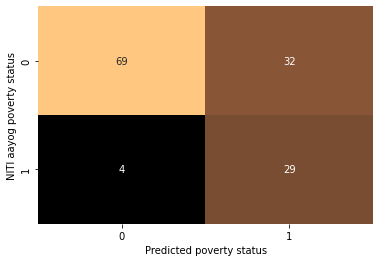


Cohen's Kappa = 0.437


In [ ]:
# Cohen's Kappa between the judgement Vector and NITI aayog classification vector
cm0 = confusion_matrix(Y_0, Y)
sns.heatmap(cm0, cbar=False, annot=True, cmap="copper")
plt.xlabel('Predicted poverty status')
plt.ylabel('NITI aayog poverty status')
plt.show()

print("\nCohen's Kappa =", cohen_kappa(cm0))

# Logistic Regression

### Setup

In [ ]:
# Choosing the test and train split with highest accuracy
def high_accuracy_split(scores, X, Y):
    k = np.argmax(scores)
    i = -1
    for train_index, test_index in cv.split(X):
        i = i+1
        if i==k:
            X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
          
    return [X_train, X_test, Y_train, Y_test]

In [ ]:
# Defining the non negative constraints on beta
def get_bounds(X):
    return Bounds(np.append(np.repeat(0.0, X.shape[1]), [-np.inf]), np.repeat(np.inf, X.shape[1]+1))

In [ ]:
# Fitting the Logistic Model and getting the beta with highest cross validation accuracy
def get_beta(X, Y):
    bounds = get_bounds(X)
    scores = cross_val_score(model, X, Y, fit_params={'bounds':bounds}, scoring='accuracy', cv=cv, n_jobs=-1)  # fitting model
    split = high_accuracy_split(scores, X, Y)    # getting the highest accuracy split
    model.fit(split[0], split[2], bounds=bounds)
    beta = model.coef_[0]/sum(model.coef_[0])   # diving by the sum of beta to scale down the coefficients
    threshold = -model.intercept_[0]/sum(model.coef_[0])
    log_likelihood = sum(Y*(model.intercept_[0] + np.matmul(X, model.coef_[0]))) - sum(np.log(1 + np.exp((model.intercept_[0] + np.matmul(X, model.coef_[0])))))
    cm = confusion_matrix(Y, model.predict(X))
    # class_rep = classification_report(Y, model.predict(X))
    accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    precision = cm[0,0]/(cm[0,0]+cm[1,0])
    return beta, threshold, cm, log_likelihood, precision, accuracy

In [ ]:
# Setting up logistic regression
cv = KFold(n_splits=5, random_state=0, shuffle=True)
model = cLogisticRegression(penalty='none')

### Original Data - Without disease

In [ ]:
beta1, threshold1, cm1, log_l1, prec1, accu1 = get_beta(X.drop(['disease'], axis=1), Y)
print(pd.DataFrame(data={'Variables':X.drop(['disease'], axis=1).columns, 'Beta_(scaled)':np.around(beta1, 4)}))
print('\nThreshold_(scaled) =', threshold1)

                       Variables  Beta_(scaled)
0                      Nutrition         0.0276
1   Child & Adolescent Mortality         0.0512
2                 Antenatal Care         0.0391
3             Years of schooling         0.0000
4              school attendance         0.0206
5                   cooking fuel         0.0799
6                    sanitation          0.0308
7                 drinking water         0.0000
8                    electricity         0.4703
9                        housing         0.0583
10                        assets         0.1208
11                  bank account         0.1015

Threshold_(scaled) = 0.13275884989369002


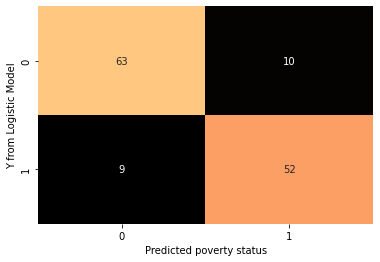


Cohen's Kappa = 0.715

Accuracy = 0.86

Precision = 0.88


In [ ]:
sns.heatmap(cm1, cbar=False, annot=True, cmap="copper")
plt.xlabel('Predicted poverty status')
plt.ylabel('Y from Logistic Model')
plt.show()

print("\nCohen's Kappa =", cohen_kappa(cm1))
print("\nAccuracy =", np.round(accu1, 2))
print('\nPrecision =', np.round(prec1, 2))

### Original Data - With disease

In [ ]:
beta2, threshold2, cm2, log_l2, prec2, accu2 = get_beta(X, Y)
print(pd.DataFrame(data={'Variables':X.columns, 'Beta_(scaled)':np.around(beta2, 4)}))
print('\nThreshold_(scaled) =', threshold2)

                       Variables  Beta_(scaled)
0                      Nutrition         0.0343
1   Child & Adolescent Mortality         0.0633
2                 Antenatal Care         0.0134
3             Years of schooling         0.0320
4              school attendance         0.0000
5                   cooking fuel         0.1215
6                    sanitation          0.0175
7                 drinking water         0.0000
8                    electricity         0.4083
9                        housing         0.0467
10                        assets         0.1208
11                  bank account         0.1341
12                       disease         0.0082

Threshold_(scaled) = 0.166855319099565


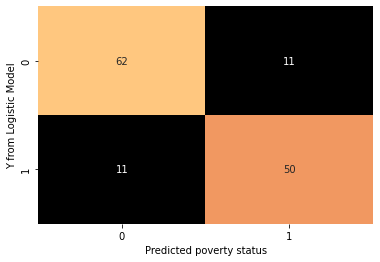


Cohen's Kappa = 0.669

Accuracy = 0.84

Precision = 0.85


In [ ]:
sns.heatmap(cm2, cbar=False, annot=True, cmap="copper")
plt.xlabel('Predicted poverty status')
plt.ylabel('Y from Logistic Model')
plt.show()

print("\nCohen's Kappa =", cohen_kappa(cm2))
print("\nAccuracy =", np.round(accu2, 2))
print('\nPrecision =', np.round(prec2, 2))

### Merging electricity and assests

In [ ]:
# Listing all the columns of X
X.columns

Index(['Nutrition', 'Child & Adolescent Mortality', 'Antenatal Care',
       'Years of schooling', 'school attendance', 'cooking fuel',
       'sanitation ', 'drinking water', 'electricity', 'housing', 'assets',
       'bank account', 'disease'],
      dtype='object')

In [ ]:
# Merging Electricity and Assests using "OR" function
X['electricity or assets'] = np.sign(X.iloc[:,8]+X.iloc[:,10])
X = X.drop(['electricity', 'assets'], axis=1)

In [ ]:
# New columns of X
X.columns

Index(['Nutrition', 'Child & Adolescent Mortality', 'Antenatal Care',
       'Years of schooling', 'school attendance', 'cooking fuel',
       'sanitation ', 'drinking water', 'housing', 'bank account', 'disease',
       'electricity or assets'],
      dtype='object')

### Merged Data - Without disease

In [ ]:
beta3, threshold3, cm3, log_l3, prec3, accu3 = get_beta(X.drop(['disease'], axis=1), Y)
print(pd.DataFrame(data={'Variables':X.drop(['disease'], axis=1).columns, 'Beta_(scaled)':np.around(beta3, 4)}))
print('\nThreshold_(scaled) =', threshold3)

                       Variables  Beta_(scaled)
0                      Nutrition         0.0520
1   Child & Adolescent Mortality         0.0965
2                 Antenatal Care         0.0740
3             Years of schooling         0.0000
4              school attendance         0.0386
5                   cooking fuel         0.1506
6                    sanitation          0.0583
7                 drinking water         0.0000
8                        housing         0.1099
9                   bank account         0.1914
10         electricity or assets         0.2287

Threshold_(scaled) = 0.2503862984281999


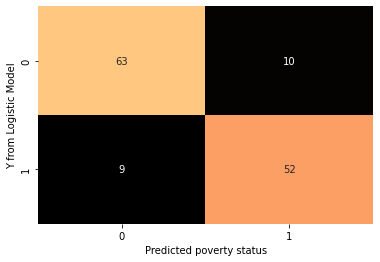


Cohen's Kappa = 0.715

Accuracy = 0.86

Precision = 0.88


In [ ]:
sns.heatmap(cm3, cbar=False, annot=True, cmap="copper")
plt.xlabel('Predicted poverty status')
plt.ylabel('Y from Logistic Model')
plt.show()

print("\nCohen's Kappa =", cohen_kappa(cm3))
print("\nAccuracy =", np.round(accu3, 2))
print('\nPrecision =', np.round(prec3, 2))

### Merged Data - With disease

In [ ]:
beta4, threshold4, cm4, log_l4, prec4, accu4 = get_beta(X, Y)
print(pd.DataFrame(data={'Variables':X.columns, 'Beta_(scaled)':np.around(beta4, 4)}))
print('\nThreshold_(scaled) =', threshold4)

                       Variables  Beta_(scaled)
0                      Nutrition         0.0577
1   Child & Adolescent Mortality         0.1068
2                 Antenatal Care         0.0230
3             Years of schooling         0.0537
4              school attendance         0.0000
5                   cooking fuel         0.2052
6                    sanitation          0.0296
7                 drinking water         0.0000
8                        housing         0.0787
9                   bank account         0.2264
10                       disease         0.0139
11         electricity or assets         0.2049

Threshold_(scaled) = 0.28165859867930565


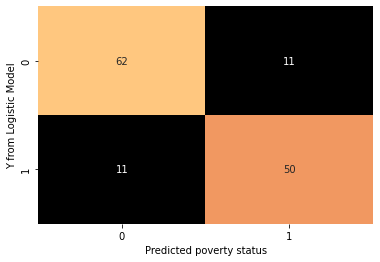


Cohen's Kappa = 0.669

Accuracy = 0.84

Precision = 0.85


In [ ]:
sns.heatmap(cm4, cbar=False, annot=True, cmap="copper")
plt.xlabel('Predicted poverty status')
plt.ylabel('Y from Logistic Model')
plt.show()

print("\nCohen's Kappa =", cohen_kappa(cm4))
print("\nAccuracy =", np.round(accu4, 2))
print('\nPrecision =', np.round(prec4, 2))